In [1]:
from tqdm import tqdm

import matplotlib.pyplot  as plt 

import numpy as np
import pipe  as pp
import glob
import os
import cv2 as cv

import auto_labeling.guided as alg
sample_shape = (512,512,3)

In [3]:
def imshow(img_bgr, ax=plt, **kwarg):
    nax = len(img_bgr.shape)
    if nax == 3:
      img_bgr = np.flip(img_bgr, axis=nax-1)
    ax.imshow(img_bgr, **kwarg)
    
# function to load data automatically basing on shape
def load_data(path, shape):
    fl_npylike = glob.glob(os.path.join(path, "*.npy"))
    fl_basenames = list(fl_npylike | pp.map(os.path.basename))

    fl_images   = next(fl_basenames | pp.filter(lambda s: "images"       in s and f"{shape[0]}_{shape[1]}" in s))
    fl_gtruth   = next(fl_basenames | pp.filter(lambda s: "ground_truth" in s and f"{shape[0]}_{shape[1]}" in s))
    fl_metadata = next(fl_basenames | pp.filter(lambda s: "metadata"     in s and f"{shape[0]}_{shape[1]}" in s))
    fl_params   = next(fl_basenames | pp.filter(lambda s: "parameters"   in s and f"{shape[0]}_{shape[1]}" in s))
    fl_fitness  = next(fl_basenames | pp.filter(lambda s: "fitness"      in s and f"{shape[0]}_{shape[1]}" in s))

    imgs   = np.load(os.path.join(path, fl_images))
    target = np.load(os.path.join(path, fl_params))

    return imgs, target

In [4]:
images, target = load_data("../dataset/", sample_shape)

In [5]:
N = 3
labeler = alg.PSTLabeler()
out_shp = list(images.shape)
out_shp[-1] = N*out_shp[-1]
pst_images = np.zeros(out_shp, dtype=np.single)
for k in range(1,N+1):
    for i, (img, opt_p) in enumerate(zip(tqdm(images), target)):
        new_p = opt_p.copy()
        new_p[2] = min((2**(k-1))*new_p[2], 1.0)
        p = alg.PSTParameters(*new_p, morph_flag=False)
        #img_g = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        labeler.set_params(p)
        pst_images[i,:,:,(k-1)*N + 0] = labeler.apply(img[:,:, 0], flag_raw=True).edges
        pst_images[i,:,:,(k-1)*N + 1] = labeler.apply(img[:,:, 1], flag_raw=True).edges
        pst_images[i,:,:,(k-1)*N + 2] = labeler.apply(img[:,:, 2], flag_raw=True).edges

  0%|          | 0/450 [00:00<?, ?it/s]/home/nzuri/Projects/TP-OptiLabel/auto_labeling/auto_labeling/guided/pst_labeling.py:57: UserWarning: thresh_min or thresh_max has no effect since morph_flag is not True.
  warn("thresh_min or thresh_max has no effect since morph_flag is not True.")
100%|██████████| 450/450 [00:04<00:00, 107.55it/s]


In [6]:
np.save(f"../dataset/partial_pstimages_{sample_shape[0]}_{sample_shape[1]}.npy", pst_images, allow_pickle=False)

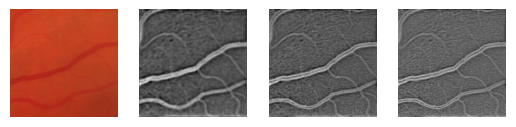

In [13]:
f, axarr = plt.subplots(1,4)
for a in axarr:
    a.axis("off")
rint = np.random.randint(0, len(images))
imshow(images[rint], axarr[0])
imshow(pst_images[rint][:,:,1], axarr[1], cmap=plt.cm.gray)
imshow(pst_images[rint][:,:,4], axarr[2], cmap=plt.cm.gray)
imshow(pst_images[rint][:,:,7], axarr[3], cmap=plt.cm.gray)